In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pso_python.BOSS_PSO import BOSS_PSO
from BOSS.BOSS_Spectra import read_fits
from definitions import PROJECT_ROOT

torch.set_grad_enabled(False)

In [2]:
pso = BOSS_PSO()

Loading grid 1:   0%|          | 0/18122 [00:00<?, ?it/s]

Loading grid 2:   0%|          | 0/23562 [00:00<?, ?it/s]

Loading grid 3:   0%|          | 0/5814 [00:00<?, ?it/s]

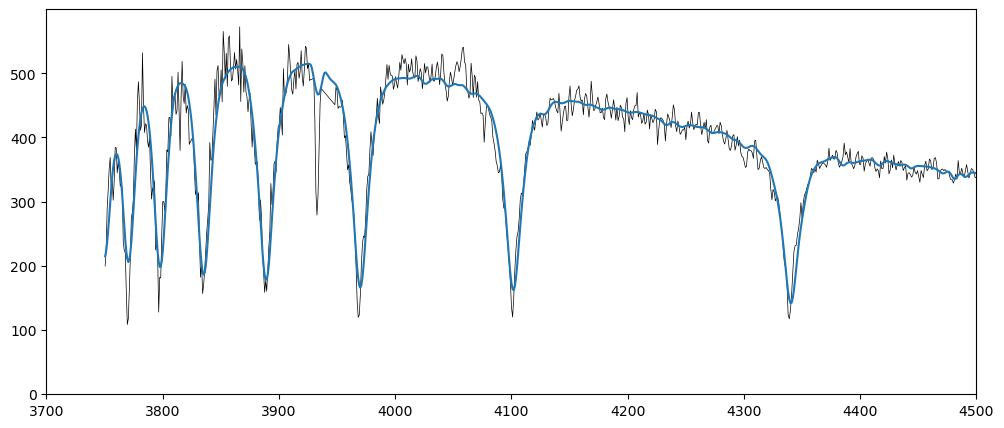

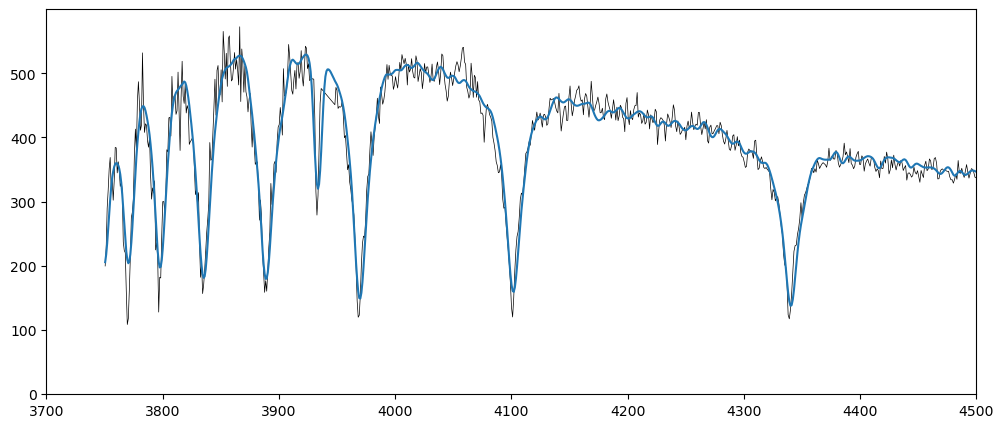

In [17]:
pso.set_observed(read_fits('BOSS_spectra/spec-016340-59629-27021597912071649.fits'))
model = pso.produce_model(torch.tensor([10248.3, 0.03256, 3.9124, 103.2136, 0.0]))
continuum = pso.fit_continuum(model)

plt.figure(figsize=(12,5))
plt.plot(pso.observed[:,0], pso.observed[:,1], color='black', lw=0.5)
plt.plot(pso.observed[:,0], continuum * model)
plt.xlim((3700, 4500))
#plt.xlim((4000, 5000))
plt.show()

model = pso.produce_model(torch.tensor([8250, 0.0, 3.0, 103.2136, 0.0]))
continuum = pso.fit_continuum(model)

plt.figure(figsize=(12,5))
plt.plot(pso.observed[:,0], pso.observed[:,1], color='black', lw=0.5)
plt.plot(pso.observed[:,0], continuum * model)
plt.xlim((3700, 4500))
#plt.xlim((4000, 5000))
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

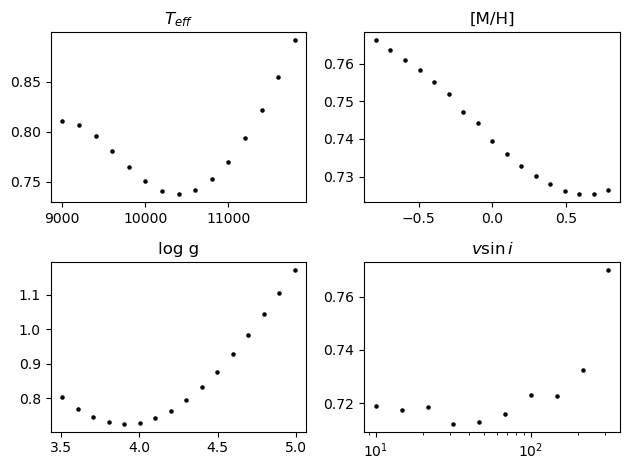

In [15]:
fig, ax = plt.subplots(2, 2)

teff = list(range(9000, 12000, 200))
chi2 = []

for t in tqdm(teff):
    chi2.append(pso.calculate_cost(torch.tensor([t, 0.03256, 3.9124, 103.2136, 0.0])))

t_best = teff[chi2.index(min(chi2))]

ax[0,0].scatter(teff, chi2, color='black', s=5)
ax[0,0].set_title('$T_{eff}$')

m_h = list(np.linspace(-0.79, 0.79, 17))
chi2 = []

for m in tqdm(m_h):
    chi2.append(pso.calculate_cost(torch.tensor([t_best, m, 3.9124, 103.2136, 0.0])))

m_best = m_h[chi2.index(min(chi2))]

ax[0,1].scatter(m_h, chi2, color='black', s=5)
ax[0,1].set_title('[M/H]')

logg = list(np.linspace(3.51, 4.99, 16))
chi2 = []

for l in tqdm(logg):
    chi2.append(pso.calculate_cost(torch.tensor([t_best, m_best, l, 103.2136, 0.0])))

l_best = logg[chi2.index(min(chi2))]

ax[1,0].scatter(logg, chi2, color='black', s=5)
ax[1,0].set_title('log g')

vsini = list(np.logspace(1, 2.5, 10))
chi2 = []

for v in tqdm(vsini):
    chi2.append(pso.calculate_cost(torch.tensor([t_best, m_best, l_best, v, 0.0])))

v_best = vsini[chi2.index(min(chi2))]

ax[1,1].scatter(vsini, chi2, color='black', s=5)
ax[1,1].semilogx()
ax[1,1].set_title('$v\\sin i$')

plt.tight_layout()
plt.show()


In [12]:
teff = list(np.linspace(6000, 10000, 16))
logg = list(np.linspace(3.01, 4.49, 16))

chi2 = np.zeros((len(teff), len(logg)))

for i, t in tqdm(enumerate(teff), total=16):
    for j, l in tqdm(enumerate(logg), total=16, leave=False):
        chi2[i, j] = pso.calculate_cost(torch.tensor([t, 0.0, l, 103.2136, 0.0]))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

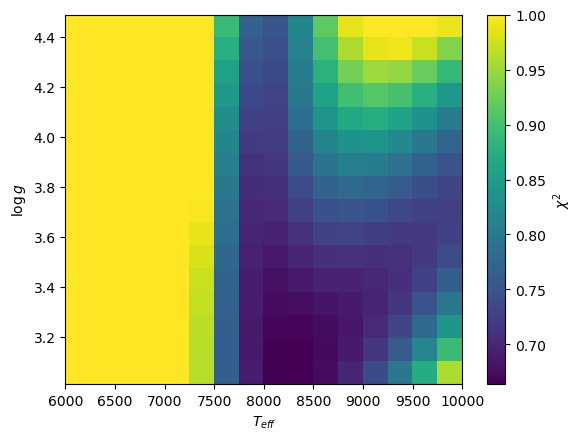

In [14]:
plt.imshow(chi2.T, extent=[min(teff), max(teff), min(logg), max(logg)], aspect='auto', origin='lower', vmax=1.0)
plt.colorbar(label='$\\chi^2$')
plt.xlabel('$T_{eff}$')
plt.ylabel('$\\log g$')
plt.show()

## Resolution Convolution

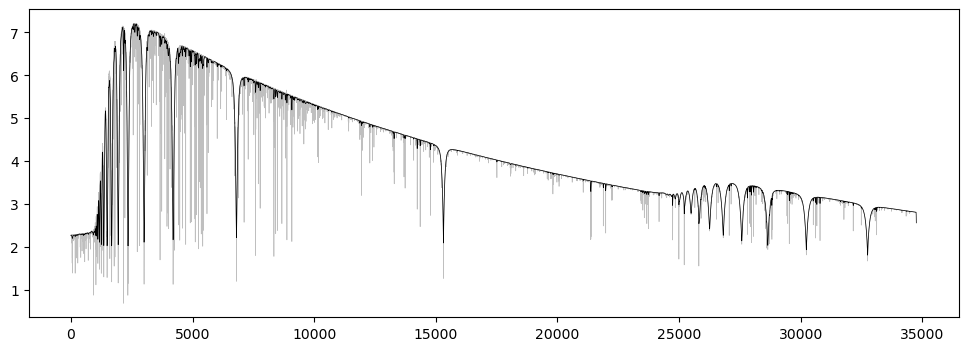

In [3]:
# Function to create Gaussian kernels for all elements in parallel
def create_gaussian_kernels(size, sigmas):
    x = torch.arange(-size // 2 + 1., size // 2 + 1., device=sigmas.device)
    x = x.view(1, -1)  # Shape: (1, kernel_size)
    sigmas = sigmas.view(-1, 1)  # Shape: (batch_size, 1)
    kernels = torch.exp(-0.5 * (x / sigmas)**2)
    kernels = kernels / kernels.sum(dim=1, keepdim=True)
    return kernels

# Parameters
kernel_size = 41  # Assume a constant kernel size for simplicity
padding = kernel_size // 2

# Sample data
Y = pso.interpolate(10143.0, 0.0325, 3.925)
S = torch.from_numpy(np.linspace(1, 0, len(Y))**2 * 5 + 5)

# Pad Y for convolution
Y_padded = F.pad(Y, (padding, padding), mode='constant')
for i in range(padding):
    Y_padded[i] = Y[0]
    Y_padded[len(Y_padded)-i-1] = Y[0]

# Generate Gaussian kernels
kernels = create_gaussian_kernels(kernel_size, S)

# Perform convolution in parallel
Y_padded = Y_padded.unfold(0, kernel_size, 1)  # Shape: (batch_size, kernel_size)
Y_new = (Y_padded * kernels).sum(dim=1)

plt.figure(figsize=(12,4))
plt.plot(Y, color='gray', alpha=0.5, lw=0.5)
plt.plot(Y_new, color='black', lw=0.5)
#plt.xlim((0, 5000))
plt.show()

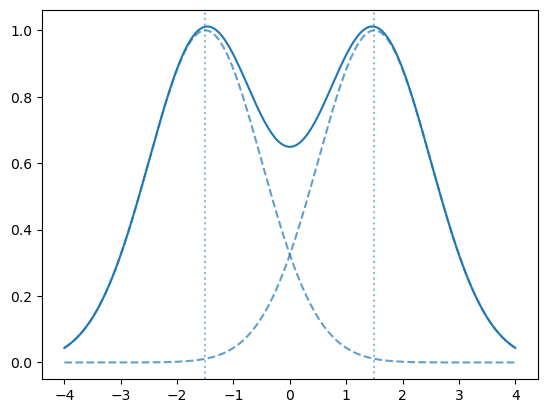

In [28]:
from General.MathUtils import gaussian

x = np.linspace(-4, 4, 1000)
delta = 3
y1 = gaussian(x, -delta/2, 1, 1)
y2 = gaussian(x, delta/2, 1, 1)

plt.plot(x, y1, color='tab:blue', alpha=0.7, ls='--')
plt.plot(x, y2, color='tab:blue', alpha=0.7, ls='--')
plt.plot(x, y1+y2, color='tab:blue')
plt.axvline(-delta/2, ls=':', color='tab:blue', alpha=0.5)
plt.axvline(delta/2, ls=':', color='tab:blue', alpha=0.5)
plt.show()

In [2]:
model = np.load('lm0010_06000_0250.npy')
wl = np.logspace(np.log10(3500), np.log10(10450), len(model))

print(1 / (np.log10(wl[1]) - np.log10(wl[0])) / 3)
print(np.log10(wl[1]) - np.log10(wl[0]))

61402.18438872159
5.428688517383762e-06


In [6]:
model = pso.model_grid2[0,0,0].unsqueeze(0).unsqueeze(0)
kernel = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.2]).unsqueeze(0).unsqueeze(0)

F.conv1d(model, kernel)

print(model.squeeze().size())

torch.Size([34751])
